In [1]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from tvb_inversion.pymc3.plot import plot_posterior_samples
from tvb_inversion.base.diagnostics import (zscore, shrinkage)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
inference_data = az.from_netcdf("pymc3_data/2023-01-03_1552.nc")
inference_summary = pd.read_json("pymc3_data/2023-01-03_1552.json")

In [3]:
X = inference_data.observed_data.x_obs.values

In [4]:
chains = len(inference_data.sample_stats.chain)
draws = len(inference_data.sample_stats.draw)

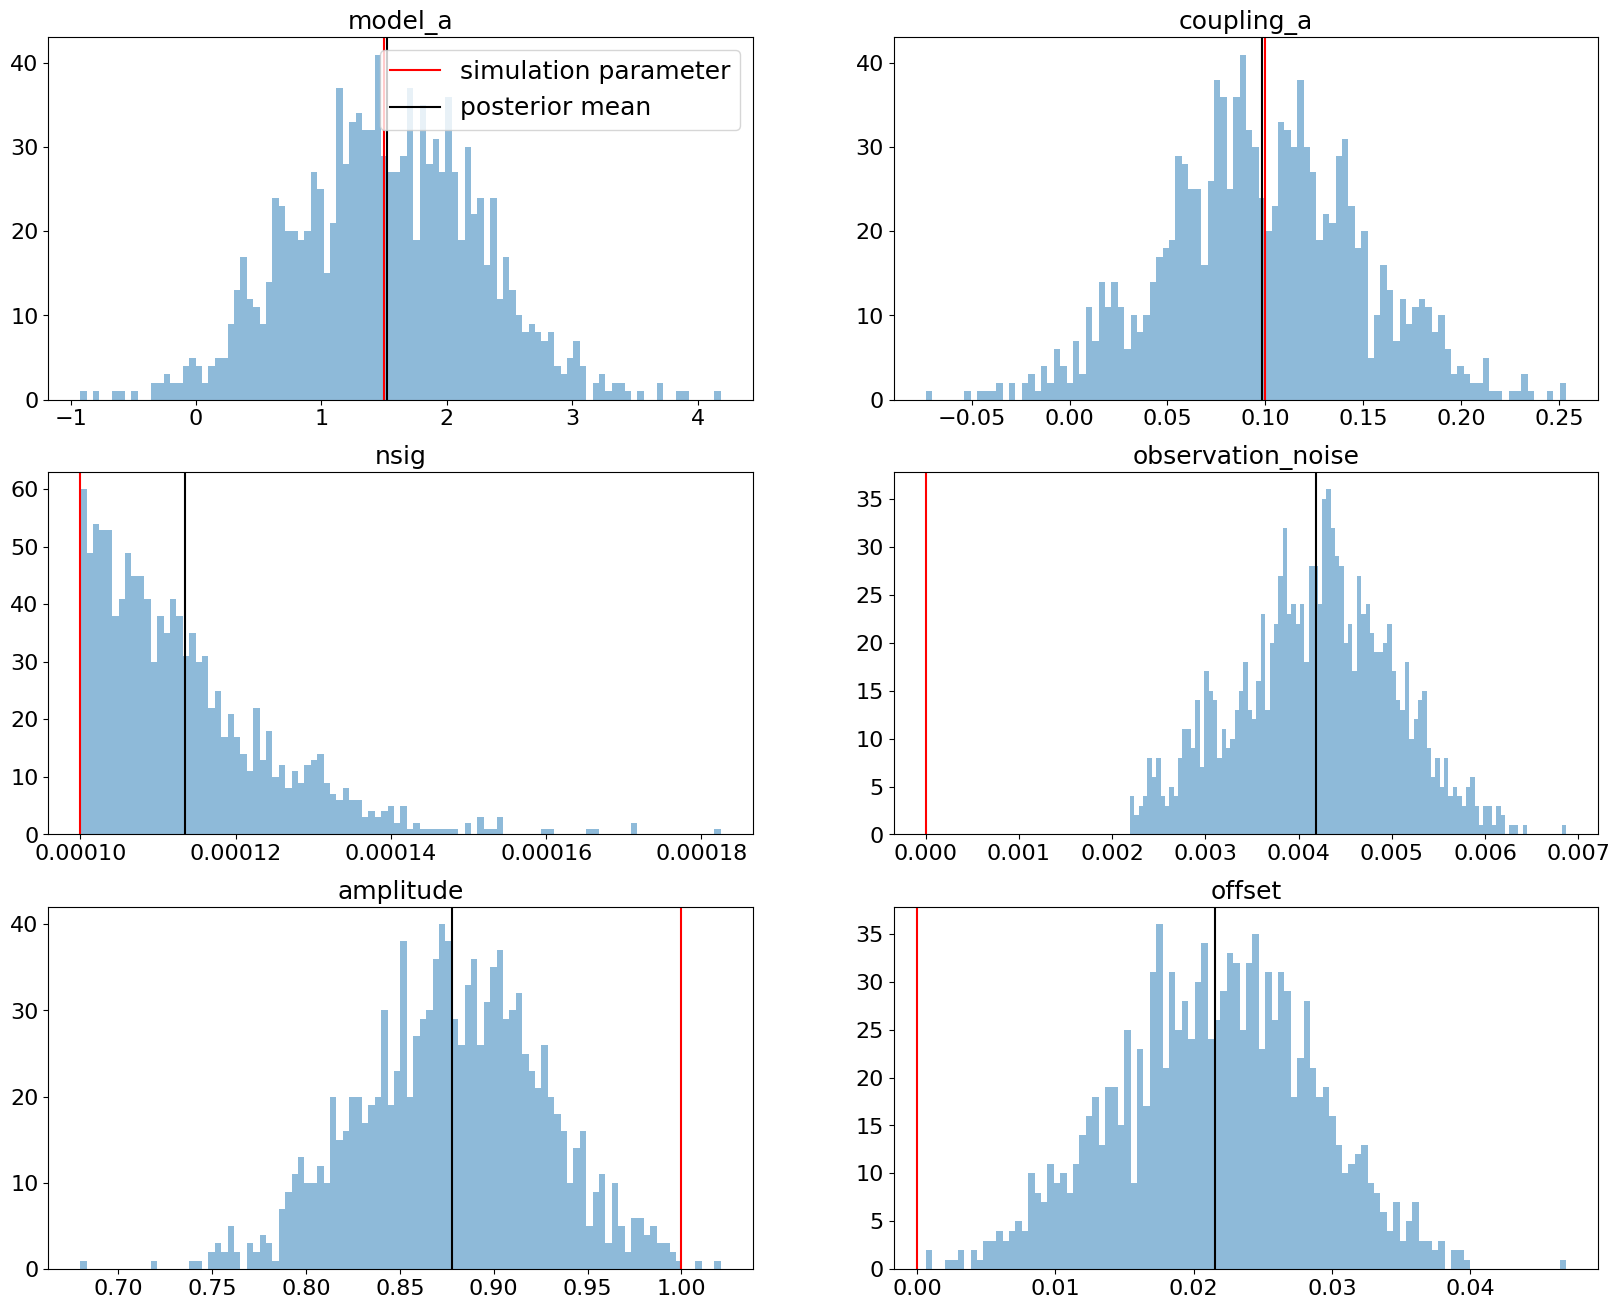

In [5]:
init_params = {
    "model_a": 1.5,
    "coupling_a": 0.1,
    "nsig": 1e-4,
    "observation_noise": 0.0,
    "amplitude": 1.0,
    "offset": 0.0
}

plot_posterior_samples(inference_data, init_params)

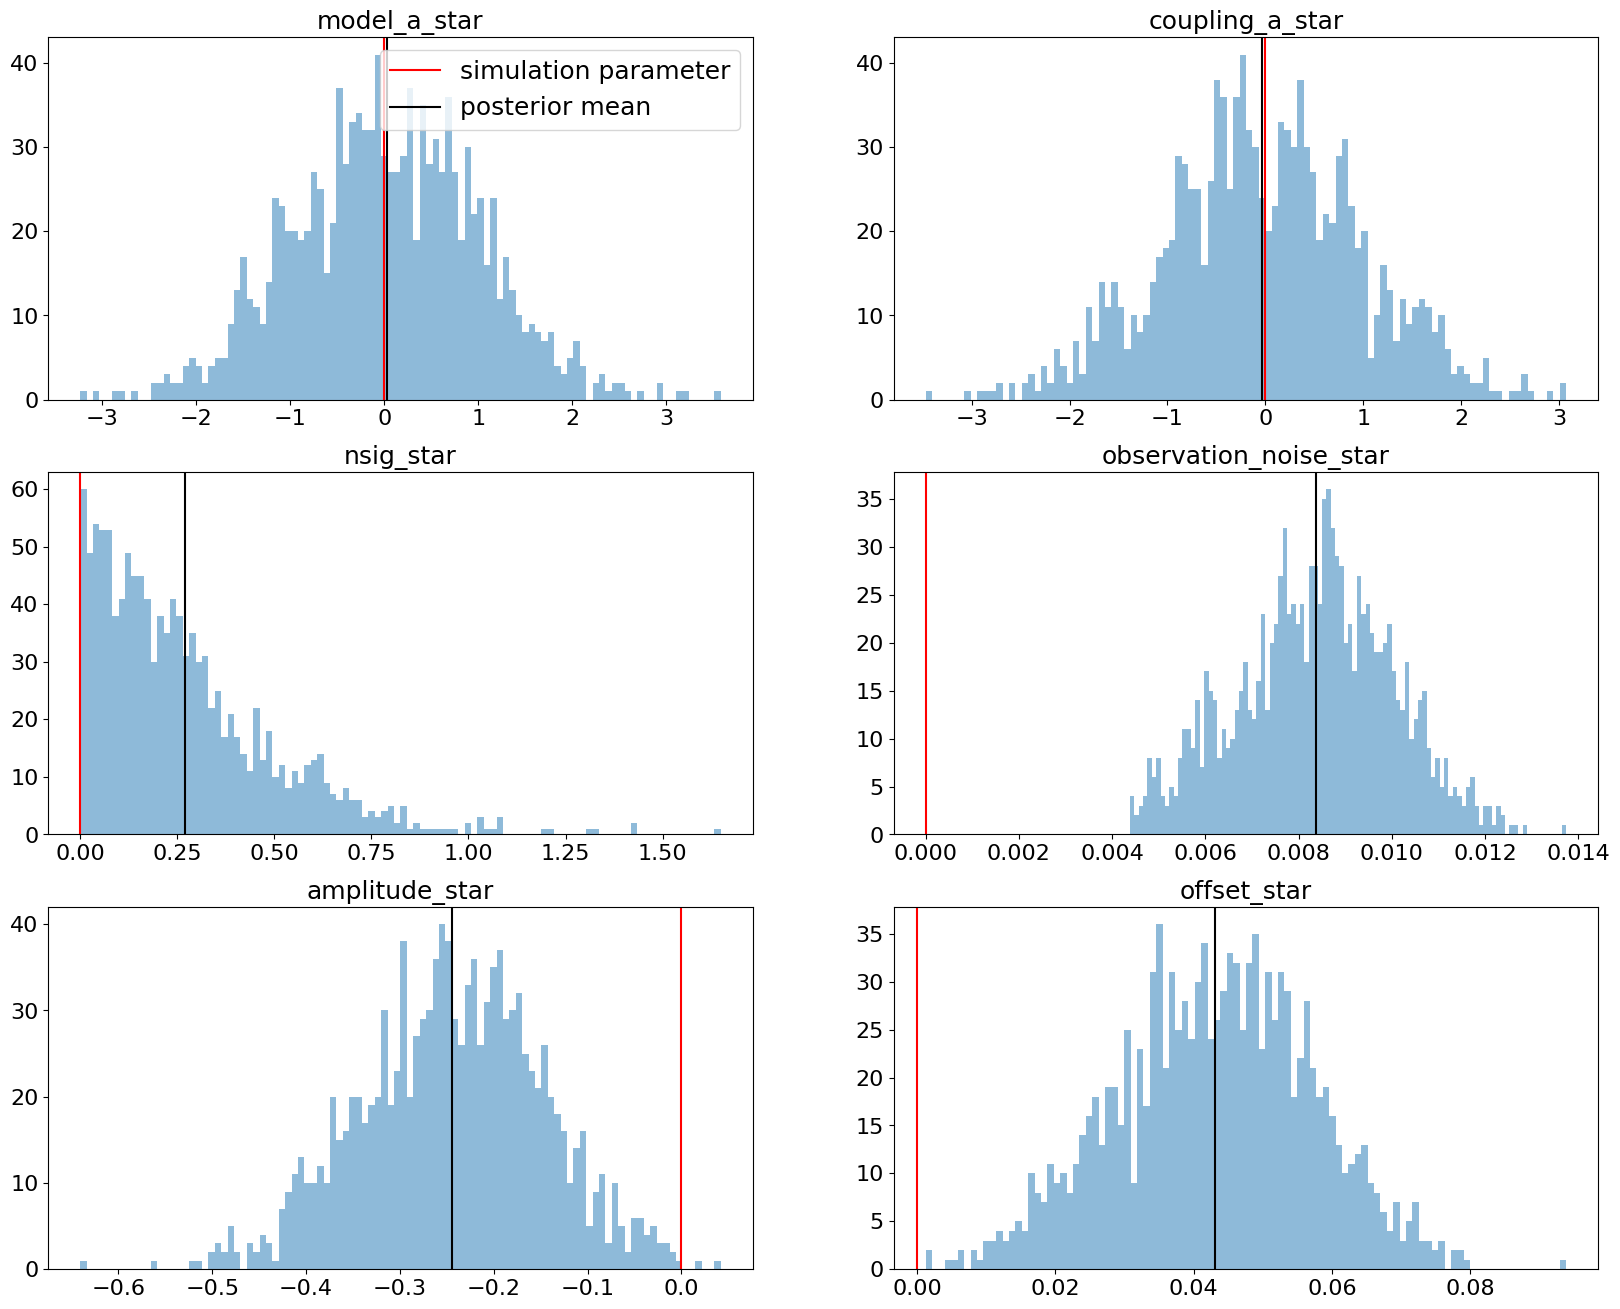

In [6]:
init_params = {
    "model_a_star": 0.0,
    "coupling_a_star": 0.0,
    "nsig_star": 0.0,
    "observation_noise_star": 0.0,
    "amplitude_star": 0.0,
    "offset_star": 0.0
}

plot_posterior_samples(inference_data, init_params)

In [7]:
posterior_x_obs = inference_data.posterior_predictive.x_obs.values.reshape(
    (chains*draws, *X.shape))

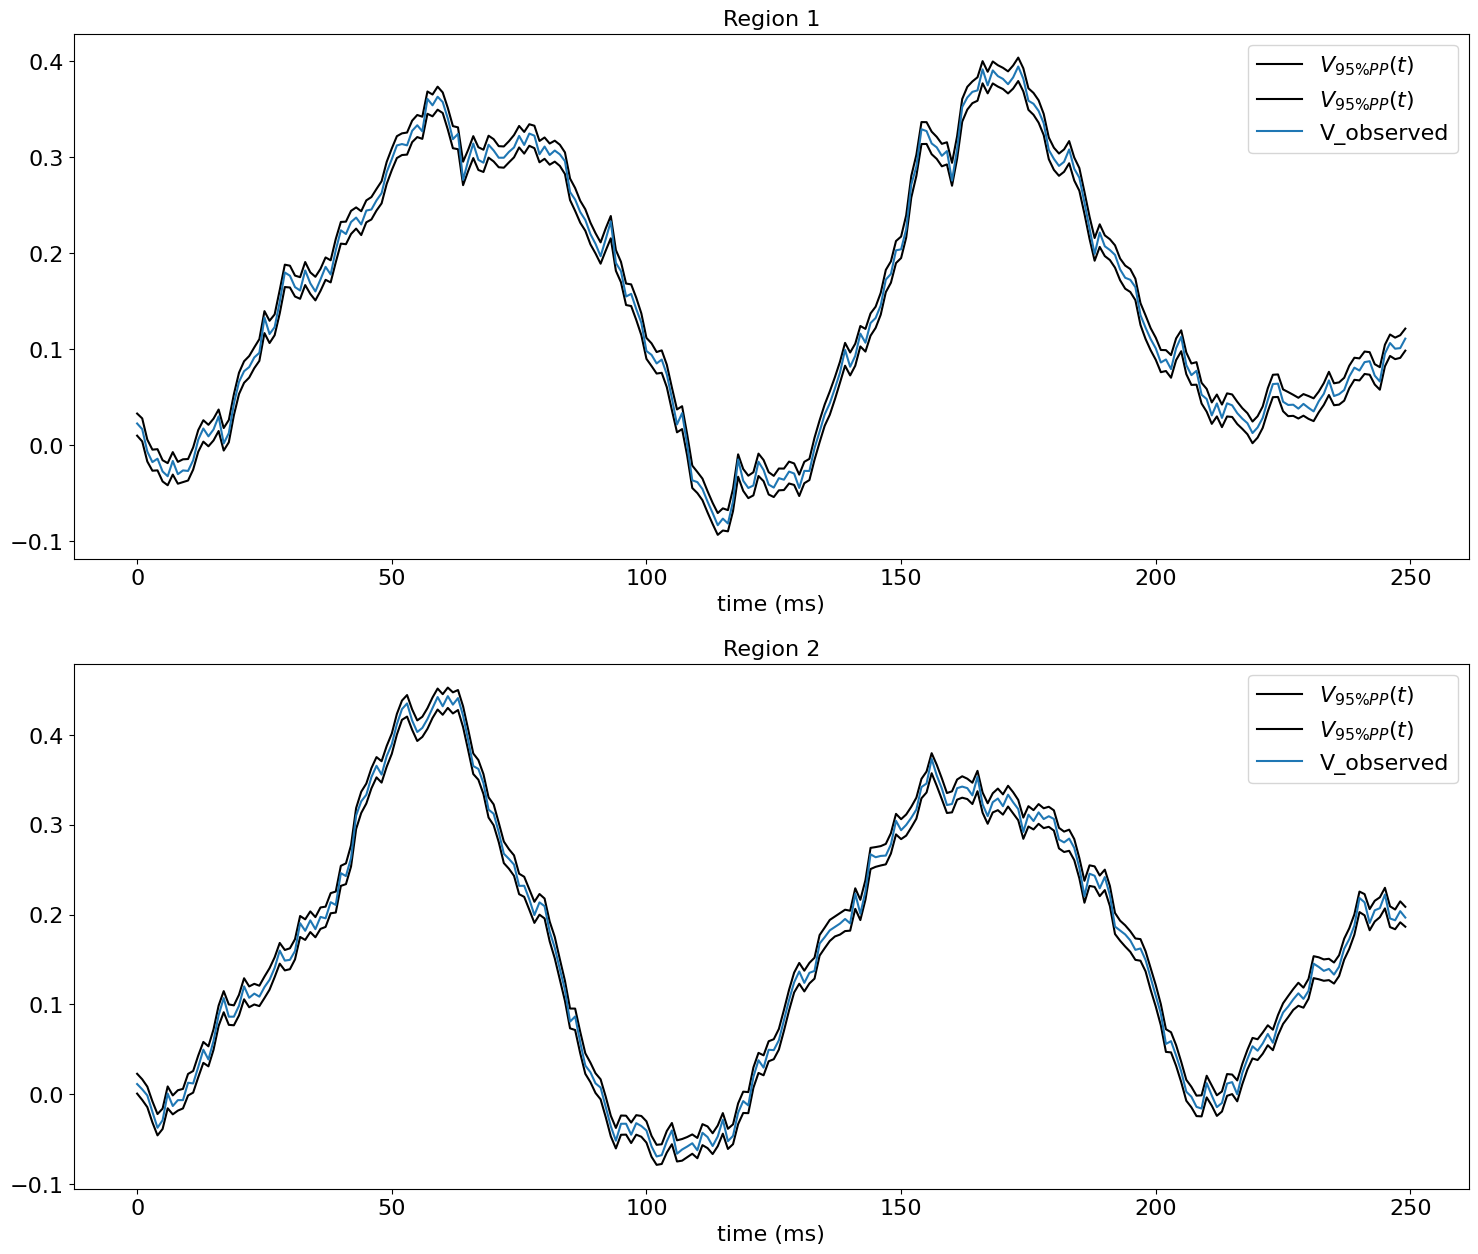

In [8]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0], [2.5, 97.5], axis=0).T,
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0], label="V_observed")
axes3[0].set_title("Region 1", fontsize=16)
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1], [2.5, 97.5], axis=0).T,
              "k", label=r"$V_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1], label="V_observed")
axes3[1].set_title("Region 2", fontsize=16)
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [9]:
inference_summary.loc[
    ["model_a_star[0]", "coupling_a_star", "nsig_star",
     "amplitude_star", "offset_star", "observation_noise_star"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_a_star[0],0.026,0.991,-1.840,1.806,0.025,0.030,1504,961,1.00
coupling_a_star,-0.033,1.013,-1.830,1.912,0.024,0.032,1856,838,1.00
nsig_star,0.270,0.230,0.000,0.680,0.011,0.008,415,500,1.01
amplitude_star,-0.244,0.098,-0.424,-0.066,0.012,0.009,64,230,1.05
offset_star,0.043,0.014,0.015,0.068,0.001,0.001,228,577,1.02
observation_noise_star,0.008,0.002,0.005,0.011,0.000,0.000,13,14,1.26


In [10]:
inference_summary.loc[
    ["model_a[0]", "coupling_a", "nsig",
     "amplitude", "offset", "observation_noise"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_a[0],1.519,0.743,0.120,2.855,0.019,0.015,1504,961,1.00
coupling_a,0.098,0.051,0.008,0.196,0.001,0.001,1856,838,1.00
nsig,0.000,0.000,0.000,0.000,0.000,0.000,415,500,1.01
amplitude,0.878,0.049,0.788,0.967,0.006,0.004,64,230,1.05
offset,0.022,0.007,0.008,0.034,0.000,0.000,228,577,1.02
observation_noise,0.004,0.001,0.002,0.006,0.000,0.000,13,14,1.26


In [11]:
def get_posterior_mean(idata, params):
    posterior = np.asarray([idata.posterior[param].values.reshape((idata.posterior[param].values.size,)) for param in params])
    return posterior.mean(axis=1)

def get_posterior_std(idata, params):
    posterior = np.asarray([idata.posterior[param].values.reshape((idata.posterior[param].values.size,)) for param in params])
    return posterior.std(axis=1)

In [12]:
# zscores
posterior_mean = get_posterior_mean(inference_data,
    ["model_a", "coupling_a", "nsig", "amplitude", "offset", "observation_noise"])

posterior_std = get_posterior_std(inference_data,
    ["model_a", "coupling_a", "nsig", "amplitude", "offset", "observation_noise"])

ground_truth = np.array(
    [1.5, 0.1, 1e-4, 1.0, 0.0, 0.0])

zscores = zscore(ground_truth, posterior_mean, posterior_std)

In [13]:
# shrinkages
posterior_std = get_posterior_std(inference_data,
    ["model_a_star", "coupling_a_star", "nsig_star",
     "amplitude_star", "offset_star", "observation_noise_star"])

prior_std = np.ones((6,))

shrinkages = shrinkage(prior_std, posterior_std)

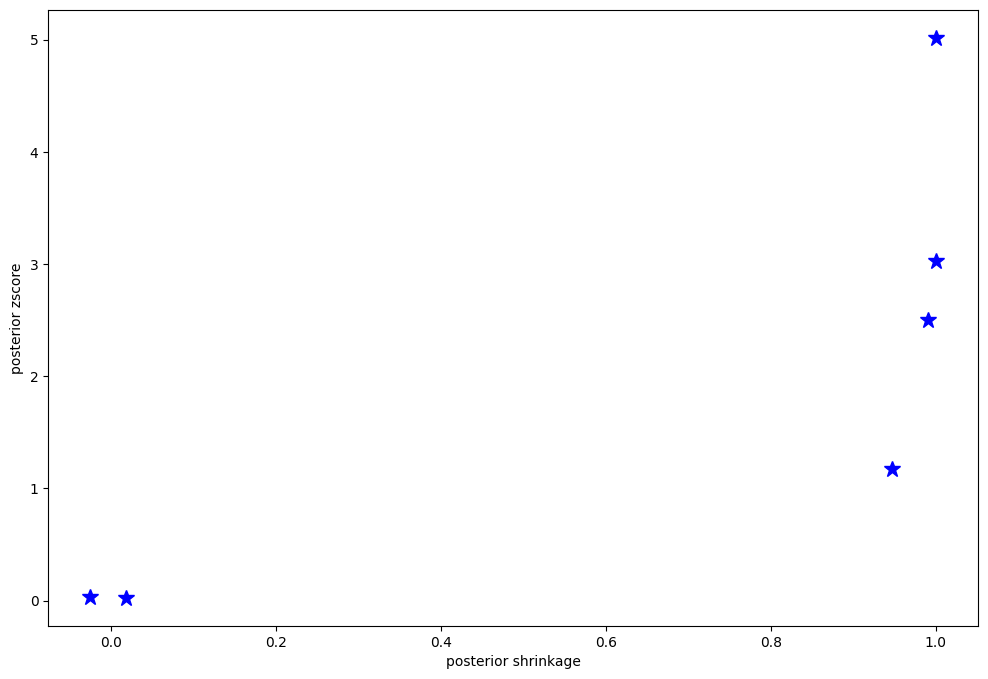

In [14]:
f4 = plt.figure(figsize=(12,8))
plt.plot(shrinkages, zscores, color="blue", linewidth=0, marker="*", markersize=12)
plt.xlabel("posterior shrinkage")
plt.ylabel("posterior zscore")
plt.plot();